In [2]:
%pip install matplotlib numpy pandas IPython


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# --- **Résolution de Sudoku avec Greedy Best First Search** ---

Ce notebook présente l'implémentation et l'évaluation de l'algorithme **Greedy Best First Search (GBFS)** pour résoudre des grilles de Sudoku (de taille `9x9`) en utilisant plusieurs fonctions heuristiques.  

L'objectif est de comparer l'impact de chaque heuristique sur les performances de l'algorithme (temps d'exécution, nombre d'états explorés, taille maximale de la file ouverte, taux de réussite).

GBFS est un algorithme de recherche informée qui sélectionne à chaque itération l'état estimé le plus proche de l'objectif, selon une fonction heuristique `h(n)`. Il ne prend pas en compte le coût déjà parcouru (`g(n)`), contrairement à A*, et met donc particulièrement en avant la qualité de l'heuristique choisie.

### **Heuristiques implémentées**

- **$h_1$ : Nombre de cases vides**  
  Calcule simplement le nombre de cellules non remplies dans la grille.  
  → Plus cette valeur est faible, plus l'état est considéré proche de la solution.  
  → Heuristique simple, rapide à calculer, mais peu discriminante lorsque plusieurs grilles ont le même nombre de cases vides.

- **$h_2$ : Somme des tailles des domaines**  
  Pour chaque cellule vide, on calcule l'ensemble des valeurs légales (domaines) possibles en respectant les règles du Sudoku (lignes, colonnes, blocs 3×3). L'heuristique renvoie la somme de ces tailles de domaines sur toute la grille.  
  → Mesure la “flexibilité” restante. Plus cette somme est petite, plus la grille est contrainte et donc proche de la solution.  
  → Plus informative que h1, mais nécessite un calcul plus coûteux.

- **$h_3$ : Combinaison pondérée**  
  Formule générale :  
  $$
  h_3(n) = w_1 \cdot h_1(n) + w_2 \cdot h_2(n)
  $$
  Les poids `(w1, w2)` permettent de trouver un compromis entre rapidité (h1) et précision de l'évaluation (h2).  
  Plusieurs configurations de poids pourront être testées pour observer l'impact sur le comportement de GBFS.

### **Génération stricte des successeurs**
Dans ce projet, la génération de nouveaux états est **stricte** :  
- On choisit la prochaine case à remplir selon la stratégie **MRV** (*Minimum Remaining Values*) : case vide avec le plus petit nombre de valeurs légales possibles.  
- On ne génère que des successeurs **valides** (aucun état intermédiaire ne viole les règles du Sudoku).

Cette approche permet de limiter la taille de l'espace de recherche et de rendre les heuristiques plus efficaces.

In [1]:
# Imports et configuration
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

# Imports des modules du projet
from heuristics import get_heuristic_function, h1_empty_cells, h2_domain_sum, h3_weighted_combination
from gbfs_solver import GBFSSolver
from visualization import print_state, print_domains_info, plot_state
from sudoku_examples import get_example, list_examples

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

## **1. Exploration et compréhension du code**

Le but de cette section est de comprendre le fonctionnement de ce qui a été implémenté. 


In [2]:
# TESTS DE VALIDATION RAPIDE 

def quick_validation():
    """Tests rapides pour vérifier que tout fonctionne."""
    
    # Test 1: SudokuState basique
    print("\nSUDOKU STATE")
    state = get_example('medium')
    print_state(state, "État initial (medium)")

    domains = state.get_all_domains()
    print(f"\nDomaines: {domains}")
    print("\tFormat du domaine d'une case vide: {(ligne, colonne): {valeurs possibles}}")
    ex_key, ex_value = next(iter(domains.items()))
    print(f"\tExemple : \"{ex_key}: {ex_value}\" indique que la case ayant pour coordonées {ex_key} peut prendre les valeurs {ex_value}")
    
    mrv_cell = state.get_mrv_cell()
    print(f"\nLa case vide avec le plus petit nombre de valeurs possibles (MVR) est: {mrv_cell} avec {len(domains[mrv_cell])} valeurs possibles.")
    
    # Test : Heuristiques
    print("\nHEURISTIQUES")
    h1_val = h1_empty_cells(state)
    h2_val = h2_domain_sum(state)
    h3_val = h3_weighted_combination(state, w1=1.0, w2=0.1)
    
    print(f"   - h1 (cases vides): {h1_val}")
    print(f"   - h2 (somme domaines): {h2_val}")
    print(f"   - h3 (pondérée): {h3_val}")

    successors = state.generate_successors()
    print(f"\nSuccesseurs générés: {len(successors)}")
    for i, succ in enumerate(successors):
        print_state(succ, f"Successeur généré {i+1}")
    
    # Test 3: GBFS simple
    print("\nRÉSOLUTION AVEC GBFS avec h1 (cases vides)")
    solver = GBFSSolver(h1_empty_cells)
    stats = solver.solve(state)
    print_state(stats.final_state, "Solution trouvée")
    print(f"\n{stats}")


result = quick_validation()


SUDOKU STATE

=== État initial (medium) ===
┌───────┬───────┬───────┐
│ . . . │ 6 . . │ 4 . . │
│ 7 . . │ . . 3 │ 6 . . │
│ . . . │ . 9 1 │ . 8 . │
├───────┼───────┼───────┤
│ . . . │ . . . │ . . . │
│ . 5 . │ 1 8 . │ . . 3 │
│ . . . │ 3 . 6 │ . 4 5 │
├───────┼───────┼───────┤
│ . 4 . │ 2 . . │ . 6 . │
│ 9 . 3 │ . . . │ . . . │
│ . 2 . │ . . . │ 1 . . │
└───────┴───────┴───────┘
Nombre de cases vides: 58

Domaines: {(0, 0): {1, 2, 3, 5, 8}, (0, 1): {1, 3, 8, 9}, (0, 2): {1, 2, 5, 8, 9}, (0, 4): {2, 5, 7}, (0, 5): {2, 5, 7, 8}, (0, 7): {1, 2, 3, 5, 7, 9}, (0, 8): {1, 2, 7, 9}, (1, 1): {1, 8, 9}, (1, 2): {1, 2, 4, 5, 8, 9}, (1, 3): {4, 5, 8}, (1, 4): {2, 4, 5}, (1, 7): {1, 2, 5, 9}, (1, 8): {1, 2, 9}, (2, 0): {2, 3, 4, 5, 6}, (2, 1): {3, 6}, (2, 2): {2, 4, 5, 6}, (2, 3): {4, 5, 7}, (2, 6): {2, 3, 5, 7}, (2, 8): {2, 7}, (3, 0): {1, 2, 3, 4, 6, 8}, (3, 1): {1, 3, 6, 7, 8, 9}, (3, 2): {1, 2, 4, 6, 7, 8, 9}, (3, 3): {4, 5, 7, 9}, (3, 4): {2, 4, 5, 7}, (3, 5): {2, 4, 5, 7, 9}, (3, 6): {2, 7,

In [51]:
# COMPARAISON RAPIDE DES HEURISTIQUES 
def compare_heuristics(example_name: str ='easy'):
    """Compare les heuristiques"""
    
    print(f"COMPARAISON SUR UNE GRILLE DE NIVEAU '{example_name.upper()}'")
    print("=" * 50)
    
    # Configuration des tests
    tests = [
        {'name': 'h1', 'params': None},
        {'name': 'h2', 'params': None},
        {'name': 'h3', 'params': {'w1': 1.0, 'w2': 0.1}},
        {'name': 'h3', 'params': {'w1': 1.0, 'w2': 0.5}},
        {'name': 'h3', 'params': {'w1': 0.5, 'w2': 1.0}},
    ]
    
    results = []
    initial_state = get_example(example_name)
    
    for test in tests:
        print(f"\nTest {test['name']}", end=" ")
        
        # Créer heuristique
        if test['name'] == 'h3':
            def h3_func(state):
                return h3_weighted_combination(state, **test['params'])
            heuristic_func = h3_func
            test_name = f"h3({test['params']['w1']},{test['params']['w2']})"
        else:
            heuristic_func = get_heuristic_function(test['name'])
            test_name = test['name']
        
        # Résoudre
        solver = GBFSSolver(heuristic_func)
        stats = solver.solve(initial_state)
        
        # Stocker résultats
        results.append({
            'Heuristique': test_name,
            'Succès': '✅' if stats.success else '❌',
            'États_dév': stats.states_developed,
            'Temps_s': round(stats.execution_time, 4),
            'Max_open': stats.max_open_size
        })
        
        print(f"{'✅' if stats.success else '❌'} ({stats.states_developed} états)")
    
    # Afficher tableau
    df = pd.DataFrame(results)
    print(f"\nRÉSULTATS:")
    display(df)
    
    return df

# Lancer la comparaison
df_comparison = compare_heuristics('medium')


COMPARAISON SUR UNE GRILLE DE NIVEAU 'MEDIUM'

Test h1 ✅ (48393 états)

Test h2 ✅ (54401 états)

Test h3 ✅ (54401 états)

Test h3 ✅ (54401 états)

Test h3 ✅ (54401 états)

📊 RÉSULTATS:


,Heuristique,Succès,États_dév,Temps_s,Max_open
0,h1,✅,48393,10.3574,18
1,h2,✅,54401,10.6338,16
2,"h3(1.0,0.1)",✅,54401,11.5578,16
3,"h3(1.0,0.5)",✅,54401,11.5655,16
4,"h3(0.5,1.0)",✅,54401,11.8759,16


## 1. Exploration des exemples de Sudoku

In [14]:
# Affichage de tous les exemples disponibles
print("📋 EXEMPLES DE SUDOKU DISPONIBLES")
print("=" * 50)

examples_info = list_examples()
for name, description in examples_info.items():
    print(f"• {name:12} : {description}")

# %%
# Visualisation de quelques exemples
examples_to_show = ['minimal', 'easy', 'medium']

for example_name in examples_to_show:
    print(f"\n{'='*60}")
    state = get_example(example_name)
    print_state(state, f"Exemple '{example_name}'")
    
    # Afficher quelques informations sur les domaines
    domains = state.get_all_domains()
    if domains:
        domain_sizes = [len(d) for d in domains.values()]
        print(f"📊 Domaines: min={min(domain_sizes)}, max={max(domain_sizes)}, "
              f"moyenne={np.mean(domain_sizes):.1f}")

📋 EXEMPLES DE SUDOKU DISPONIBLES
• minimal      : Une seule case vide (très facile)
• almost_solved : 2-3 cases vides (test rapide)
• easy         : Sudoku facile avec plusieurs cases vides
• medium       : Sudoku de difficulté moyenne
• hard         : Sudoku difficile (beaucoup de cases vides)
• empty        : Grille complètement vide (test extrême)


=== Exemple 'minimal' ===
┌───────┬───────┬───────┐
│ 5 3 4 │ 6 7 8 │ 9 1 2 │
│ 6 7 2 │ 1 9 5 │ 3 4 8 │
│ 1 9 8 │ 3 4 2 │ 5 6 7 │
├───────┼───────┼───────┤
│ 8 5 9 │ 7 6 1 │ 4 2 3 │
│ 4 2 6 │ 8 5 3 │ 7 9 1 │
│ 7 1 3 │ 9 2 4 │ 8 5 6 │
├───────┼───────┼───────┤
│ 9 6 1 │ 5 3 7 │ 2 8 4 │
│ 2 8 7 │ 4 1 9 │ 6 3 5 │
│ 3 4 5 │ 2 8 6 │ 1 7 . │
└───────┴───────┴───────┘
Nombre de cases vides: 1
📊 Domaines: min=1, max=1, moyenne=1.0


=== Exemple 'easy' ===
┌───────┬───────┬───────┐
│ 5 3 . │ . 7 . │ . . . │
│ 6 . . │ 1 9 5 │ . . . │
│ . 9 8 │ . . . │ . 6 . │
├───────┼───────┼───────┤
│ 8 . . │ . 6 . │ . . 3 │
│ 4 . . │ 8 . 3 │ . . 1 │
│ 7 . . │ .

## 2. Test des heuristiques individuelles

In [17]:
def test_heuristic_on_example(example_name, heuristic_name, heuristic_params=None):
    """Teste une heuristique sur un exemple et retourne les résultats."""
    
    # Charger l'exemple
    initial_state = get_example(example_name)
    
    # Créer le solveur
    heuristic_func = get_heuristic_function(heuristic_name)
    solver = GBFSSolver(heuristic_func)
    
    # Résoudre
    if heuristic_params:
        stats = solver.solve_with_params(initial_state, heuristic_params, max_iterations=50000)
    else:
        stats = solver.solve(initial_state, max_iterations=50000)
    
    return stats

# Test de h1 sur l'exemple 'easy'
print("🧪 TEST DE L'HEURISTIQUE H1")
print("=" * 40)

example_name = 'easy'
initial_state = get_example(example_name)
print_state(initial_state, "État initial")

# Tester h1
stats_h1 = test_heuristic_on_example(example_name, 'h1')
print(f"\n📈 Résultats avec h1:")
print(stats_h1)

if stats_h1.success:
    print_state(stats_h1.final_state, "Solution trouvée")

# %%
# Test de h2 sur le même exemple
print("🧪 TEST DE L'HEURISTIQUE H2")
print("=" * 40)

stats_h2 = test_heuristic_on_example(example_name, 'h2')
print(f"📈 Résultats avec h2:")
print(stats_h2)

# %%
# Test de h3 avec différents poids
print("🧪 TEST DE L'HEURISTIQUE H3 (PONDÉRÉE)")
print("=" * 40)

h3_configs = [
    {'w1': 1.0, 'w2': 0.1, 'name': 'h3_standard'},
    {'w1': 1.0, 'w2': 0.5, 'name': 'h3_equilibre'},
    {'w1': 0.5, 'w2': 1.0, 'name': 'h3_domaines'},
    {'w1': 2.0, 'w2': 0.05, 'name': 'h3_cases'},
]

h3_results = {}
for config in h3_configs:
    params = {'w1': config['w1'], 'w2': config['w2']}
    stats = test_heuristic_on_example(example_name, 'h3', params)
    h3_results[config['name']] = stats
    
    print(f"\n📊 {config['name']} (w1={config['w1']}, w2={config['w2']}):")
    print(f"   Succès: {'✅' if stats.success else '❌'}")
    print(f"   États développés: {stats.states_developed}")
    print(f"   Temps: {stats.execution_time:.4f}s")


🧪 TEST DE L'HEURISTIQUE H1

=== État initial ===
┌───────┬───────┬───────┐
│ 5 3 . │ . 7 . │ . . . │
│ 6 . . │ 1 9 5 │ . . . │
│ . 9 8 │ . . . │ . 6 . │
├───────┼───────┼───────┤
│ 8 . . │ . 6 . │ . . 3 │
│ 4 . . │ 8 . 3 │ . . 1 │
│ 7 . . │ . 2 . │ . . 6 │
├───────┼───────┼───────┤
│ . 6 . │ . . . │ 2 8 . │
│ . . . │ 4 1 9 │ . . 5 │
│ . . . │ . 8 . │ . 7 9 │
└───────┴───────┴───────┘
Nombre de cases vides: 51

📈 Résultats avec h1:
=== Statistiques GBFS ===
Résultat: SUCCÈS
États développés: 52
Taille max open list: 1
Temps d'exécution: 0.0107s


=== Solution trouvée ===
┌───────┬───────┬───────┐
│ 5 3 4 │ 6 7 8 │ 9 1 2 │
│ 6 7 2 │ 1 9 5 │ 3 4 8 │
│ 1 9 8 │ 3 4 2 │ 5 6 7 │
├───────┼───────┼───────┤
│ 8 5 9 │ 7 6 1 │ 4 2 3 │
│ 4 2 6 │ 8 5 3 │ 7 9 1 │
│ 7 1 3 │ 9 2 4 │ 8 5 6 │
├───────┼───────┼───────┤
│ 9 6 1 │ 5 3 7 │ 2 8 4 │
│ 2 8 7 │ 4 1 9 │ 6 3 5 │
│ 3 4 5 │ 2 8 6 │ 1 7 9 │
└───────┴───────┴───────┘
Nombre de cases vides: 0
🧪 TEST DE L'HEURISTIQUE H2
📈 Résultats avec h2:
=== Statisti

## 3. Comparaison systématique des heuristiques

🔬 COMPARAISON COMPREHENSIVE

📋 Test sur l'exemple 'minimal':
  🧪 h1... ✅ (2 états, 0.000s)
  🧪 h2... ✅ (2 états, 0.000s)
  🧪 h3_std... ✅ (2 états, 0.000s)
  🧪 h3_eq... ✅ (2 états, 0.000s)
  🧪 h3_dom... ✅ (2 états, 0.000s)

📋 Test sur l'exemple 'almost_solved':
  🧪 h1... ✅ (4 états, 0.000s)
  🧪 h2... ✅ (4 états, 0.000s)
  🧪 h3_std... ✅ (4 états, 0.000s)
  🧪 h3_eq... ✅ (4 états, 0.000s)
  🧪 h3_dom... ✅ (4 états, 0.000s)

📋 Test sur l'exemple 'easy':
  🧪 h1... ✅ (52 états, 0.010s)
  🧪 h2... ✅ (52 états, 0.010s)
  🧪 h3_std... ✅ (52 états, 0.011s)
  🧪 h3_eq... ✅ (52 états, 0.011s)
  🧪 h3_dom... ✅ (52 états, 0.011s)

📋 Test sur l'exemple 'medium':
  🧪 h1... ✅ (48393 états, 9.680s)
  🧪 h2... ❌ (50000 états, 10.038s)
  🧪 h3_std... ❌ (50000 états, 11.144s)
  🧪 h3_eq... ❌ (50000 états, 10.529s)
  🧪 h3_dom... ❌ (50000 états, 11.273s)

📊 TABLEAU DES RÉSULTATS
✅ TAUX DE SUCCÈS:


heuristique,h1,h2,h3_dom,h3_eq,h3_std
exemple,,,,,
almost_solved,True,True,True,True,True
easy,True,True,True,True,True
medium,True,False,False,False,False
minimal,True,True,True,True,True



🔢 NOMBRE D'ÉTATS DÉVELOPPÉS:


heuristique,h1,h2,h3_dom,h3_eq,h3_std
exemple,,,,,
almost_solved,4,4,4,4,4
easy,52,52,52,52,52
medium,48393,50000,50000,50000,50000
minimal,2,2,2,2,2



⏱️ TEMPS D'EXÉCUTION (secondes):


heuristique,h1,h2,h3_dom,h3_eq,h3_std
exemple,,,,,
almost_solved,0.0003,0.0003,0.0004,0.0004,0.0004
easy,0.0100,0.0097,0.0111,0.0111,0.0112
medium,9.6799,10.0379,11.2731,10.5289,11.1438
minimal,0.0004,0.0002,0.0002,0.0002,0.0002


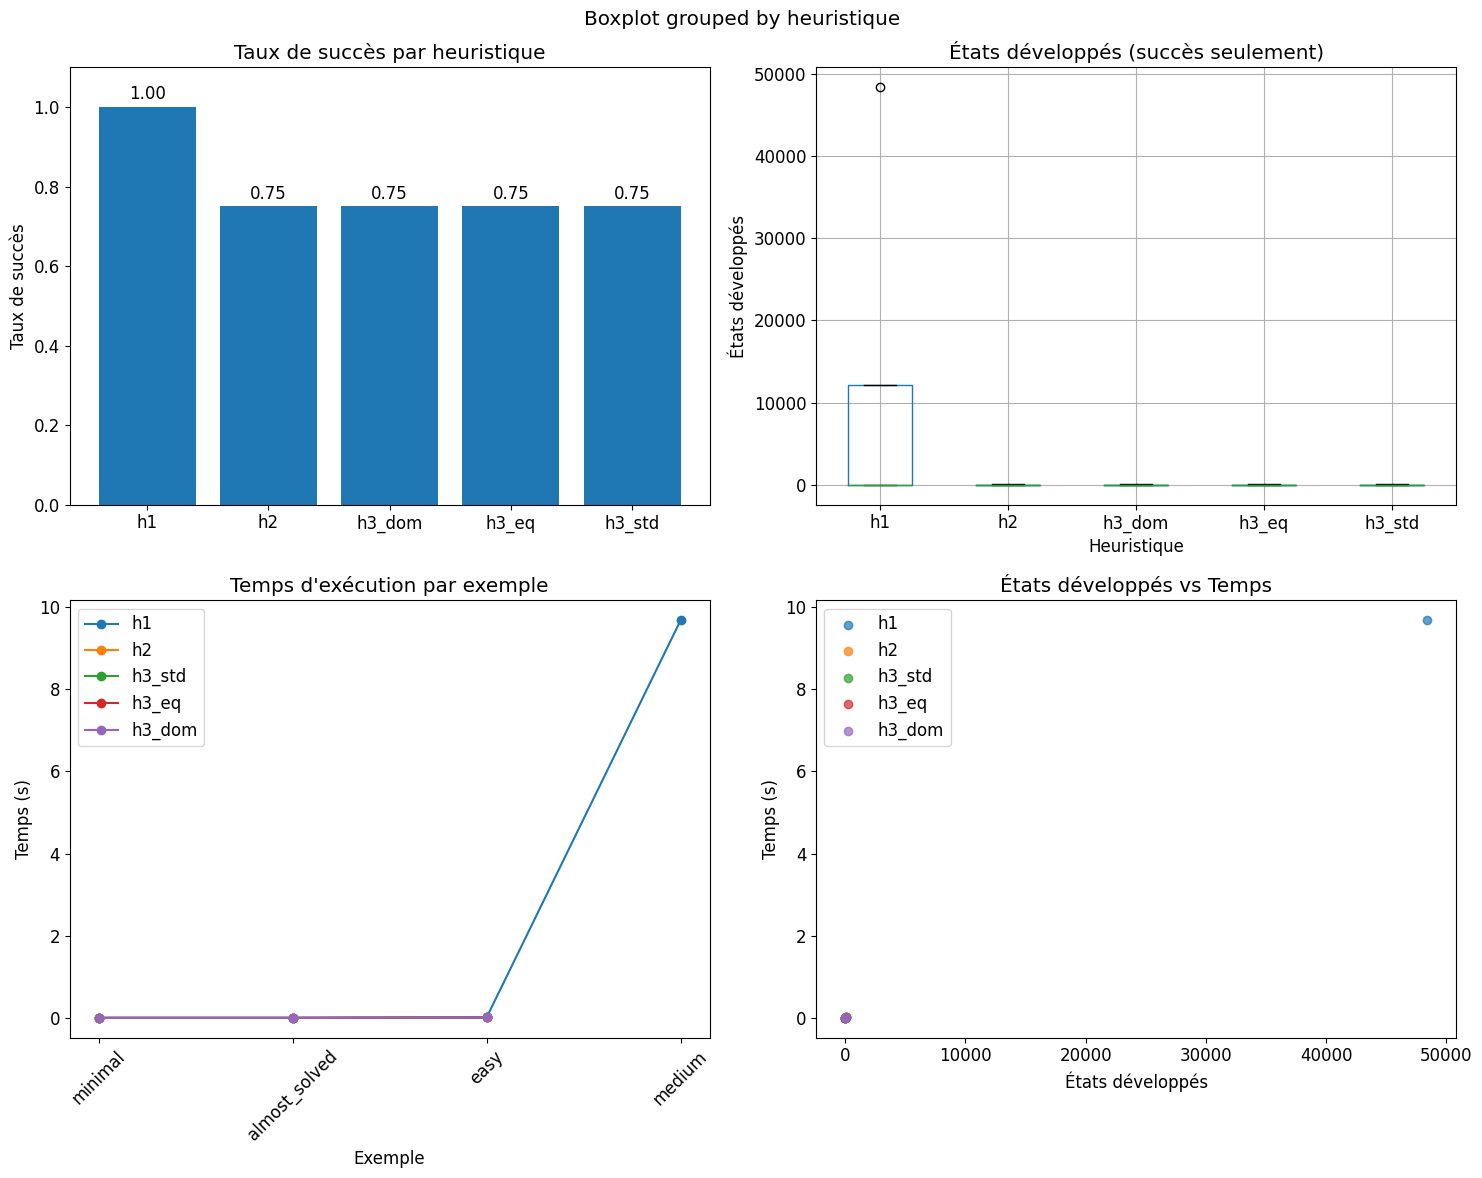

In [18]:
def run_comprehensive_comparison():
    """Compare toutes les heuristiques sur plusieurs exemples."""
    
    # Exemples à tester (du plus facile au plus difficile)
    test_examples = ['minimal', 'almost_solved', 'easy', 'medium']
    
    # Configuration des tests
    test_configs = [
        {'heuristic': 'h1', 'params': None, 'name': 'h1'},
        {'heuristic': 'h2', 'params': None, 'name': 'h2'},
        {'heuristic': 'h3', 'params': {'w1': 1.0, 'w2': 0.1}, 'name': 'h3_std'},
        {'heuristic': 'h3', 'params': {'w1': 1.0, 'w2': 0.5}, 'name': 'h3_eq'},
        {'heuristic': 'h3', 'params': {'w1': 0.5, 'w2': 1.0}, 'name': 'h3_dom'},
    ]
    
    # Stocker les résultats
    results = []
    
    print("🔬 COMPARAISON COMPREHENSIVE")
    print("=" * 60)
    
    for example_name in test_examples:
        print(f"\n📋 Test sur l'exemple '{example_name}':")
        
        for config in test_configs:
            print(f"  🧪 {config['name']}...", end=" ")
            
            try:
                stats = test_heuristic_on_example(
                    example_name, 
                    config['heuristic'], 
                    config['params']
                )
                
                result = {
                    'exemple': example_name,
                    'heuristique': config['name'],
                    'succes': stats.success,
                    'etats_dev': stats.states_developed,
                    'temps': stats.execution_time,
                    'max_open': stats.max_open_size
                }
                results.append(result)
                
                status = "✅" if stats.success else "❌"
                print(f"{status} ({stats.states_developed} états, {stats.execution_time:.3f}s)")
                
            except Exception as e:
                print(f"❌ Erreur: {e}")
                result = {
                    'exemple': example_name,
                    'heuristique': config['name'],
                    'succes': False,
                    'etats_dev': -1,
                    'temps': -1,
                    'max_open': -1
                }
                results.append(result)
    
    return pd.DataFrame(results)

# Lancer la comparaison
df_results = run_comprehensive_comparison()

# %%
# Affichage des résultats sous forme de tableau
print("\n📊 TABLEAU DES RÉSULTATS")
print("=" * 80)

# Créer un tableau pivot pour une meilleure visualisation
pivot_success = df_results.pivot(index='exemple', columns='heuristique', values='succes')
pivot_states = df_results.pivot(index='exemple', columns='heuristique', values='etats_dev')
pivot_time = df_results.pivot(index='exemple', columns='heuristique', values='temps')

print("✅ TAUX DE SUCCÈS:")
display(pivot_success)

print("\n🔢 NOMBRE D'ÉTATS DÉVELOPPÉS:")
display(pivot_states)

print("\n⏱️ TEMPS D'EXÉCUTION (secondes):")
display(pivot_time.round(4))

# %%
# Visualisation graphique des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Taux de succès par heuristique
success_by_heuristic = df_results.groupby('heuristique')['succes'].mean()
axes[0,0].bar(success_by_heuristic.index, success_by_heuristic.values)
axes[0,0].set_title('Taux de succès par heuristique')
axes[0,0].set_ylabel('Taux de succès')
axes[0,0].set_ylim(0, 1.1)
for i, v in enumerate(success_by_heuristic.values):
    axes[0,0].text(i, v + 0.02, f'{v:.2f}', ha='center')

# 2. États développés (seulement les succès)
success_data = df_results[df_results['succes'] == True]
if not success_data.empty:
    success_data.boxplot(column='etats_dev', by='heuristique', ax=axes[0,1])
    axes[0,1].set_title('États développés (succès seulement)')
    axes[0,1].set_xlabel('Heuristique')
    axes[0,1].set_ylabel('États développés')

# 3. Temps d'exécution par exemple
if not success_data.empty:
    for heuristic in success_data['heuristique'].unique():
        data = success_data[success_data['heuristique'] == heuristic]
        axes[1,0].plot(data['exemple'], data['temps'], 'o-', label=heuristic)
    axes[1,0].set_title('Temps d\'exécution par exemple')
    axes[1,0].set_xlabel('Exemple')
    axes[1,0].set_ylabel('Temps (s)')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)

# 4. Corrélation états développés vs temps
if not success_data.empty:
    for heuristic in success_data['heuristique'].unique():
        data = success_data[success_data['heuristique'] == heuristic]
        axes[1,1].scatter(data['etats_dev'], data['temps'], label=heuristic, alpha=0.7)
    axes[1,1].set_title('États développés vs Temps')
    axes[1,1].set_xlabel('États développés')
    axes[1,1].set_ylabel('Temps (s)')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

## 4. Analyse détaillée d'un cas spécifique

In [7]:
# Analyse approfondie sur un exemple medium
print("🔍 ANALYSE DÉTAILLÉE - EXEMPLE MEDIUM")
print("=" * 50)

example_name = 'medium'
initial_state = get_example(example_name)

# Afficher l'état initial avec détails
print_state(initial_state, "État initial")
print_domains_info(initial_state)

# Calculer les valeurs heuristiques initiales
print(f"\n📏 VALEURS HEURISTIQUES INITIALES:")
h1_val = h1_empty_cells(initial_state)
h2_val = h2_domain_sum(initial_state)
h3_val = h3_weighted_combination(initial_state, w1=1.0, w2=0.1)

print(f"h1 (cases vides): {h1_val}")
print(f"h2 (somme domaines): {h2_val}")
print(f"h3 (pondérée): {h3_val}")

# Tester avec plusieurs heuristiques
print(f"\n🧪 TESTS AVEC DIFFÉRENTES HEURISTIQUES:")

for heuristic_name in ['h1', 'h2']:
    print(f"\n--- Test avec {heuristic_name} ---")
    stats = test_heuristic_on_example(example_name, heuristic_name)
    print(f"Résultat: {'✅ Succès' if stats.success else '❌ Échec'}")
    if stats.success:
        print(f"États développés: {stats.states_developed}")
        print(f"Temps: {stats.execution_time:.4f}s")
        print(f"Taille max open list: {stats.max_open_size}")


🔍 ANALYSE DÉTAILLÉE - EXEMPLE MEDIUM

=== État initial ===
┌───────┬───────┬───────┐
│ . . . │ 6 . . │ 4 . . │
│ 7 . . │ . . 3 │ 6 . . │
│ . . . │ . 9 1 │ . 8 . │
├───────┼───────┼───────┤
│ . . . │ . . . │ . . . │
│ . 5 . │ 1 8 . │ . . 3 │
│ . . . │ 3 . 6 │ . 4 5 │
├───────┼───────┼───────┤
│ . 4 . │ 2 . . │ . 6 . │
│ 9 . 3 │ . . . │ . . . │
│ . 2 . │ . . . │ 1 . . │
└───────┴───────┴───────┘
Nombre de cases vides: 58

=== Informations sur les domaines (58 cases vides) ===
Case (3,2): {3, 6} (taille: 2)
Case (3,9): {2, 7} (taille: 2)
Case (6,5): {2, 7} (taille: 2)
Case (1,5): {2, 5, 7} (taille: 3)
Case (2,2): {1, 8, 9} (taille: 3)
Case (2,4): {4, 5, 8} (taille: 3)
Case (2,5): {2, 4, 5} (taille: 3)
Case (2,9): {1, 2, 9} (taille: 3)
Case (3,4): {4, 5, 7} (taille: 3)
Case (5,1): {2, 4, 6} (taille: 3)
Case (5,7): {2, 7, 9} (taille: 3)
Case (5,8): {2, 7, 9} (taille: 3)
Case (6,1): {1, 2, 8} (taille: 3)
Case (7,1): {1, 5, 8} (taille: 3)
Case (7,9): {7, 8, 9} (taille: 3)
Case (8,8): {2, 5, 7

## 5. Test sur un exemple difficile

In [8]:
# Test sur un exemple plus challengeant
print("💪 TEST SUR EXEMPLE DIFFICILE")
print("=" * 40)

hard_example = 'hard'
initial_state = get_example(hard_example)
print_state(initial_state, "Exemple difficile")

print(f"Cases vides: {len(initial_state.get_empty_cells())}")

# Test avec limite d'itérations plus élevée
solver = GBFSSolver(get_heuristic_function('h1'))
stats = solver.solve(initial_state, max_iterations=100000)

print(f"\n📊 Résultats sur exemple difficile:")
print(stats)

if stats.success:
    print("🎉 Solution trouvée!")
    plot_state(stats.final_state, "Solution de l'exemple difficile")
else:
    print("😞 Pas de solution trouvée dans la limite d'itérations")


💪 TEST SUR EXEMPLE DIFFICILE

=== Exemple difficile ===
┌───────┬───────┬───────┐
│ . . . │ . . . │ . 1 . │
│ 4 . . │ . . . │ . . . │
│ . 2 . │ . . . │ . . . │
├───────┼───────┼───────┤
│ . . . │ . 5 . │ 4 . 7 │
│ . . 8 │ . . . │ 3 . . │
│ . . 1 │ . 9 . │ . . . │
├───────┼───────┼───────┤
│ 3 . . │ 4 . . │ 2 . . │
│ . 5 . │ 1 . . │ . . . │
│ . . . │ 8 . 6 │ . . . │
└───────┴───────┴───────┘
Nombre de cases vides: 64
Cases vides: 64

📊 Résultats sur exemple difficile:
=== Statistiques GBFS ===
Résultat: ÉCHEC
États développés: 100000
Taille max open list: 27
Temps d'exécution: 17.3625s

😞 Pas de solution trouvée dans la limite d'itérations


## 6. Conclusion et observations

### Observations clés :

1. **Heuristique h1** : Simple et efficace pour les exemples faciles
2. **Heuristique h2** : Prend en compte la contrainte des domaines
3. **Heuristique h3** : Permet de balancer entre rapidité et qualité de guidage

### Points d'amélioration possibles :
- Implémenter des heuristiques plus sophistiquées
- Ajouter des techniques de préprocessing
- Tester A* au lieu de GBFS pur

### Performance :
L'algorithme GBFS fonctionne bien sur les exemples de difficulté faible à moyenne.
Pour les exemples très difficiles, il peut être nécessaire d'augmenter la limite d'itérations
ou d'utiliser des heuristiques plus informées.

In [9]:
print("✅ Expériences terminées!")
print("📊 Résultats sauvegardés dans df_results")
print("🎯 Prêt pour d'autres tests personnalisés!")

✅ Expériences terminées!
📊 Résultats sauvegardés dans df_results
🎯 Prêt pour d'autres tests personnalisés!


# Travaux sur le dataset 

📂 Dataset trouvé ! Lancement de l'analyse complète...
🚀 ANALYSE COMPLÈTE DU DATASET SUDOKU
📂 Chargement du dataset...
   ✅ 1020 grilles chargées
🔄 Conversion des grilles...
   ✅ 1020 SudokuStates créés avec succès

🔍 VALIDATION DES GRILLES
✅ Grille   0 (almost_solved_001): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   1 (almost_solved_002): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   2 (almost_solved_003): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   3 (almost_solved_004): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   4 (almost_solved_005): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   5 (almost_solved_006): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   6 (almost_solved_007): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   7 (almost_solved_008): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   8 (almost_solved_009): valide=True, cases_vides=2, givens_déclarés=79
✅ Grille   9 (almost_solved_010

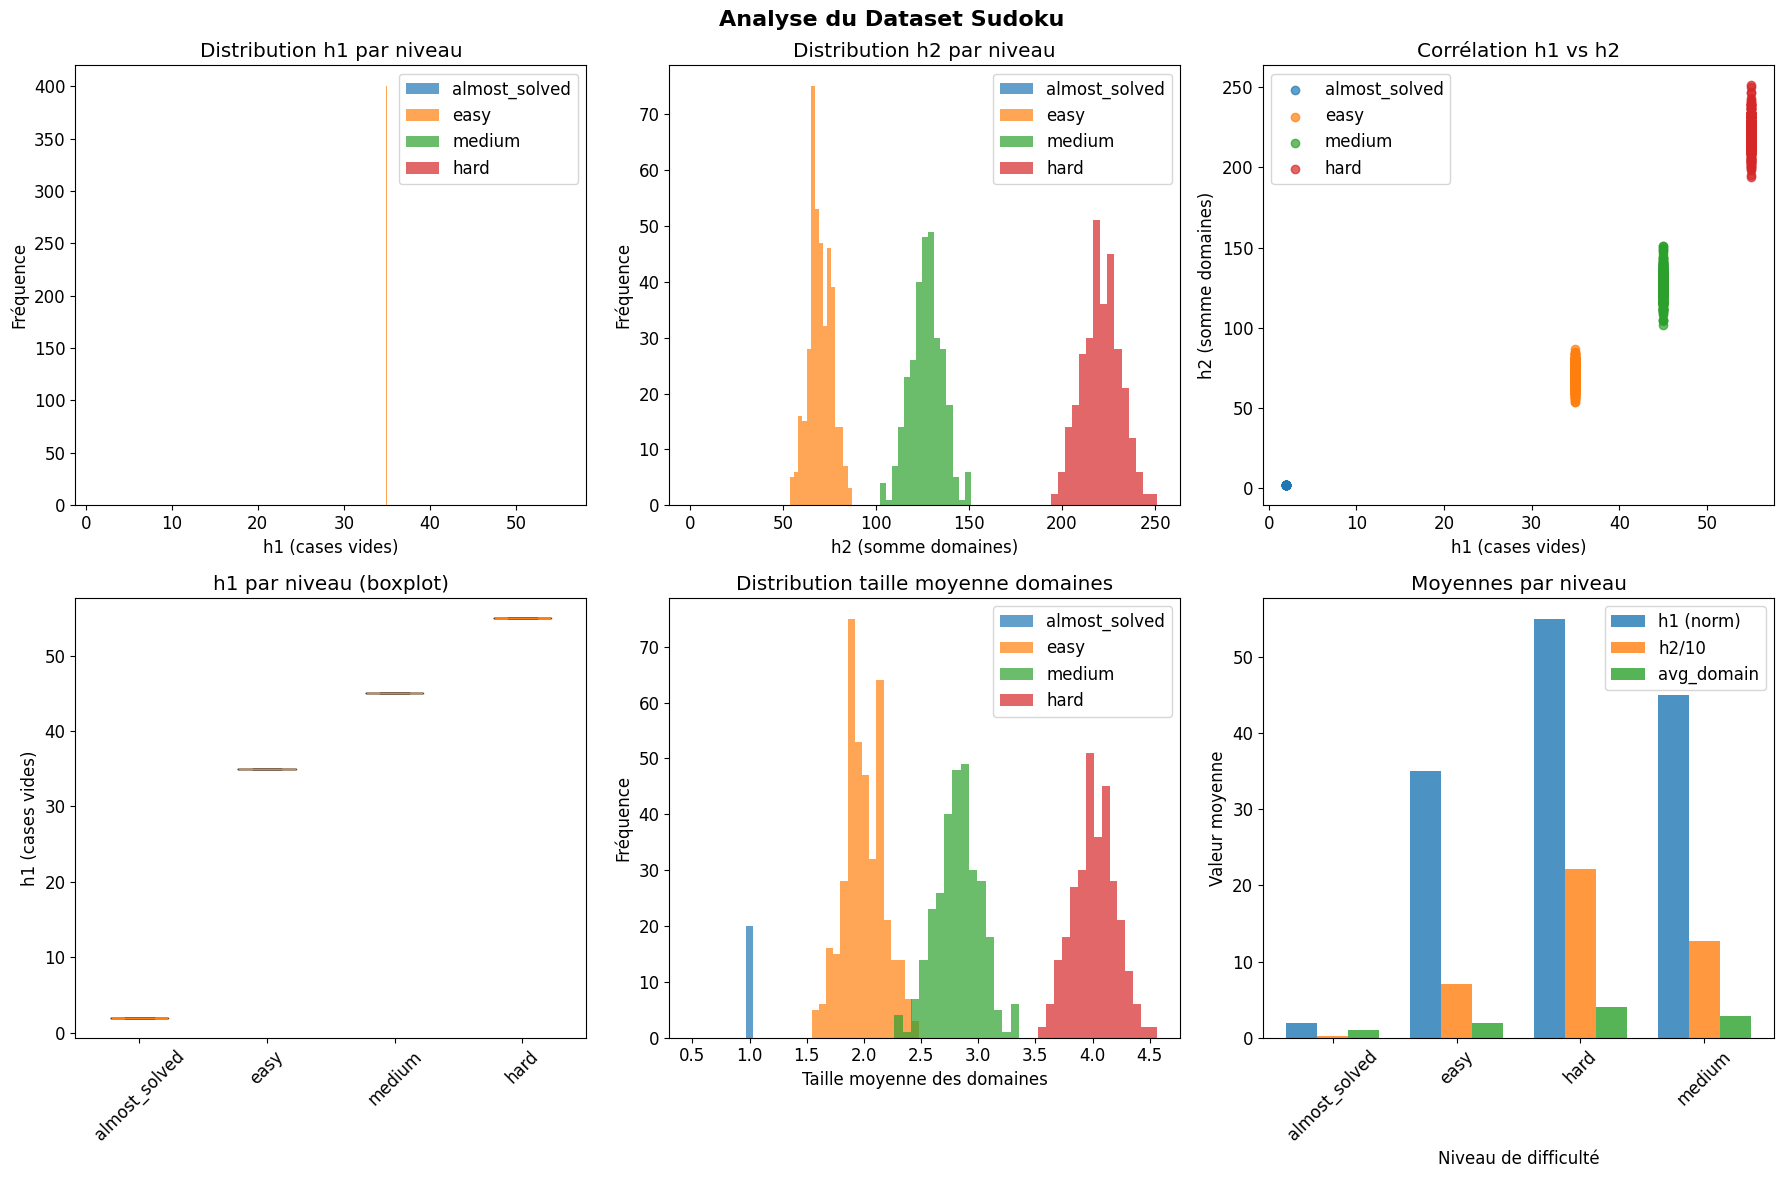


📄 GÉNÉRATION DU RAPPORT COMPLET

🧩 RAPPORT D'ANALYSE DU DATASET SUDOKU

📊 RÉSUMÉ GÉNÉRAL
-----------------
• Total de grilles: 1020
• Grilles valides: 1020 (100.0%)
• Grilles invalides: 0

📈 ANALYSE PAR NIVEAU
--------------------
🎯 Niveau 'almost_solved':
   • Nombre: 20 grilles
   • Validité: 100.0%
   • Cases vides: 2.0 ± 0.0
   • Range: [2, 2]
   • Précision givens: 100.0%
🎯 Niveau 'easy':
   • Nombre: 400 grilles
   • Validité: 100.0%
   • Cases vides: 35.0 ± 0.0
   • Range: [35, 35]
   • Précision givens: 100.0%
🎯 Niveau 'medium':
   • Nombre: 300 grilles
   • Validité: 100.0%
   • Cases vides: 45.0 ± 0.0
   • Range: [45, 45]
   • Précision givens: 100.0%
🎯 Niveau 'hard':
   • Nombre: 300 grilles
   • Validité: 100.0%
   • Cases vides: 55.0 ± 0.0
   • Range: [55, 55]
   • Précision givens: 100.0%

🧮 VALEURS HEURISTIQUES
-----------------------
• h1 moyen: 43.2 ± 10.1
• h2 moyen: 129.9 ± 65.1
• Taille domaine moyenne: 2.82

📋 RECOMMANDATIONS
------------------
✅ Ordre de difficul

h1                     h2                 
          mean    std min max    mean     std min  max
source                                                
builtin  35.40  30.84   1  64  139.20  136.05   1  303
dataset  43.18  10.08   2  55  129.85   65.13   2  251

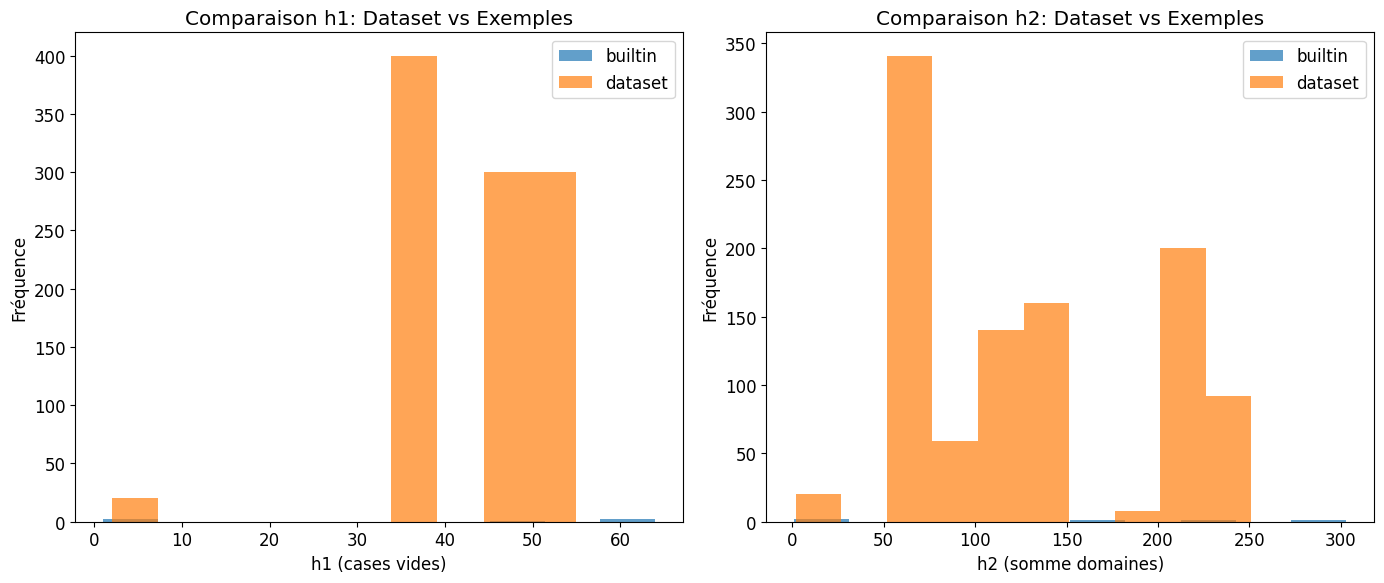

🧪 TESTS GBFS SUR GRILLES DU DATASET
🔬 Test sur 8 grilles avec 3 heuristiques
----------------------------------------------------------------------

📋 Grille 1: almost_solved_001 (niveau: almost_solved, h1: 2)
   🧪 h1... ✅ (3 états, 0.000s)
   🧪 h2... ✅ (3 états, 0.000s)
   🧪 h3... ✅ (3 états, 0.000s)

📋 Grille 2: almost_solved_002 (niveau: almost_solved, h1: 2)
   🧪 h1... ✅ (3 états, 0.000s)
   🧪 h2... ✅ (3 états, 0.000s)
   🧪 h3... ✅ (3 états, 0.000s)

📋 Grille 3: easy_001 (niveau: easy, h1: 35)
   🧪 h1... ✅ (36 états, 0.006s)
   🧪 h2... ✅ (36 états, 0.006s)
   🧪 h3... ✅ (36 états, 0.006s)

📋 Grille 4: easy_002 (niveau: easy, h1: 35)
   🧪 h1... ✅ (36 états, 0.006s)
   🧪 h2... ✅ (36 états, 0.005s)
   🧪 h3... ✅ (36 états, 0.006s)

📋 Grille 5: medium_001 (niveau: medium, h1: 45)
   🧪 h1... ✅ (46 états, 0.008s)
   🧪 h2... ✅ (46 états, 0.008s)
   🧪 h3... ✅ (46 états, 0.009s)

📋 Grille 6: medium_002 (niveau: medium, h1: 45)
   🧪 h1... ✅ (46 états, 0.008s)
   🧪 h2... ✅ (46 états, 0.008s)
  

states_developed          execution_time        max_open_size       
                      mean      std           mean    std          mean    std
heuristic                                                                     
h1                 173.375  321.616          0.026  0.046         4.625  5.927
h2                  84.625  111.096          0.014  0.018         4.250  5.148
h3                  84.625  111.096          0.014  0.019         4.250  5.148

📈 VISUALISATION DES PERFORMANCES GBFS


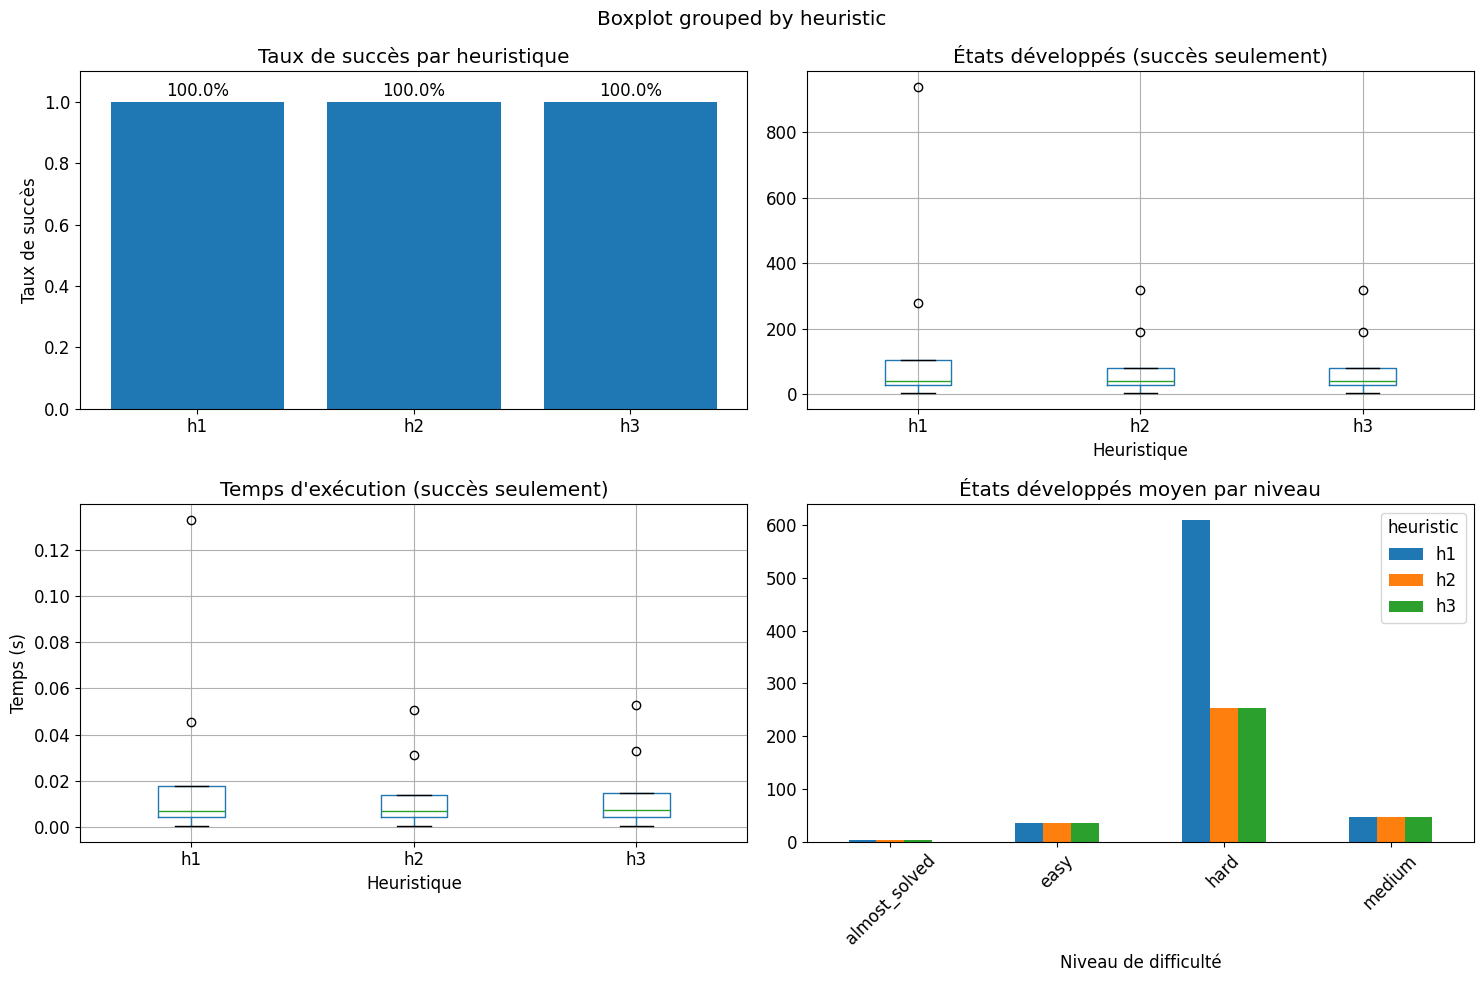


📋 TABLEAU RÉSUMÉ FINAL:


,Tests,Succès,Taux,États_moy,Temps_moy
heuristic,,,,,
h1,8,8,100.0%,173.4,0.0259
h2,8,8,100.0%,84.6,0.0137
h3,8,8,100.0%,84.6,0.0144


✅ Analyse complète du dataset terminée !
📊 Toutes les métriques et visualisations ont été générées.
💾 N'oubliez pas de sauvegarder vos résultats si nécessaire !


In [53]:
# %% [markdown]
# ## 6. 📂 Analyse du dataset CSV personnalisé
# 
# Si vous avez un fichier `sudoku_dataset.csv`, analysons-le avec nos outils !

# %%
# 📂 ANALYSE DU DATASET CSV (si disponible)
import os
from dataset_analyzer import SudokuDatasetAnalyzer, analyze_sudoku_dataset

# Vérifier si le fichier existe
csv_file = "sudoku_dataset.csv"
if os.path.exists(csv_file):
    print("📂 Dataset trouvé ! Lancement de l'analyse complète...")
    
    # Analyse complète du dataset
    analyzer = analyze_sudoku_dataset(
        csv_path=csv_file,
        show_samples=True,
        create_plots=True
    )
    
    print("\n✅ Analyse du dataset terminée !")
    
else:
    print("❌ Fichier 'sudoku_dataset.csv' non trouvé")
    print("📋 Pour utiliser cette fonctionnalité:")
    print("   1. Placez votre fichier CSV dans le même dossier")
    print("   2. Nommez-le 'sudoku_dataset.csv'")
    print("   3. Relancez cette cellule")
    
    # Créer un dataset d'exemple pour la démonstration
    print("\n🎭 Création d'un mini-dataset d'exemple...")
    
    import pandas as pd
    from sudoku_examples import get_example
    
    # Créer quelques exemples au format CSV
    example_data = []
    examples = ['minimal', 'almost_solved', 'easy']
    
    for i, ex_name in enumerate(examples):
        state = get_example(ex_name)
        grid_str = str(state.grid).replace(' ', '')  # Format compact
        
        example_data.append({
            'id': f'{ex_name}_{i+1:03d}',
            'level': ex_name,
            'givens': 81 - len(state.get_empty_cells()),
            'grid': grid_str
        })
    
    # Sauvegarder et analyser
    demo_df = pd.DataFrame(example_data)
    demo_df.to_csv('demo_dataset.csv', index=False)
    
    print("✅ Mini-dataset créé : 'demo_dataset.csv'")
    print("📊 Analyse du mini-dataset...")
    
    # Analyser le mini-dataset
    demo_analyzer = analyze_sudoku_dataset(
        csv_path='demo_dataset.csv',
        show_samples=True,
        create_plots=False  # Pas de plots pour le mini-dataset
    )

# %%
# 🔍 ANALYSE D'UNE GRILLE SPÉCIFIQUE (si dataset disponible)
if os.path.exists(csv_file) and 'analyzer' in locals():
    print("🔍 ANALYSE DÉTAILLÉE D'UNE GRILLE SPÉCIFIQUE")
    print("=" * 50)
    
    # Prendre la première grille du dataset comme exemple
    if len(analyzer.df) > 0:
        sample_id = analyzer.df.iloc[0]['id']
        sample_level = analyzer.df.iloc[0]['level']
        
        print(f"📋 Analyse de la grille: {sample_id} (niveau: {sample_level})")
        
        # Obtenir l'état
        sample_state = analyzer.sudoku_states[0]
        
        # Affichage détaillé
        print_state(sample_state, f"Grille {sample_id}")
        print_domains_info(sample_state)
        
        # Valeurs heuristiques
        h1_val = h1_empty_cells(sample_state)
        h2_val = h2_domain_sum(sample_state)
        h3_val = h3_weighted_combination(sample_state, w1=1.0, w2=0.1)
        
        print(f"\n📊 Valeurs heuristiques:")
        print(f"   h1: {h1_val}")
        print(f"   h2: {h2_val}")
        print(f"   h3: {h3_val}")
        
        # Test GBFS rapide
        print(f"\n🧪 Test GBFS sur cette grille:")
        solver = GBFSSolver(h1_empty_cells)
        stats = solver.solve(sample_state, max_iterations=5000)
        
        print(f"   Succès: {'✅' if stats.success else '❌'}")
        if stats.success:
            print(f"   États développés: {stats.states_developed}")
            print(f"   Temps: {stats.execution_time:.4f}s")
            print(f"   Max open size: {stats.max_open_size}")
else:
    print("⚠️ Pas de dataset à analyser")

# %%
# 📊 COMPARAISON DATASET vs EXEMPLES INTÉGRÉS
print("📊 COMPARAISON: DATASET vs EXEMPLES INTÉGRÉS")
print("=" * 50)

# Analyser nos exemples intégrés
builtin_examples = ['minimal', 'almost_solved', 'easy', 'medium', 'hard']
builtin_data = []

for ex_name in builtin_examples:
    try:
        state = get_example(ex_name)
        h1_val = h1_empty_cells(state)
        h2_val = h2_domain_sum(state)
        
        builtin_data.append({
            'source': 'builtin',
            'id': ex_name,
            'level': ex_name,
            'h1': h1_val,
            'h2': h2_val,
            'valid': state.is_valid()
        })
    except Exception as e:
        print(f"⚠️ Erreur avec {ex_name}: {e}")

builtin_df = pd.DataFrame(builtin_data)

# Si on a un dataset CSV, le comparer
if os.path.exists(csv_file) and 'analyzer' in locals() and 'heuristics' in analyzer.analysis_results:
    dataset_df = analyzer.analysis_results['heuristics'][['id', 'level', 'h1', 'h2']].copy()
    dataset_df['source'] = 'dataset'
    dataset_df['valid'] = True  # Déjà filtré pour les valides
    
    # Combiner les données
    comparison_df = pd.concat([builtin_df, dataset_df], ignore_index=True)
    
    print("📈 Statistiques comparées:")
    comparison_stats = comparison_df.groupby('source').agg({
        'h1': ['mean', 'std', 'min', 'max'],
        'h2': ['mean', 'std', 'min', 'max']
    }).round(2)
    
    display(comparison_stats)
    
    # Visualisation comparative
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # h1 comparison
    for source in comparison_df['source'].unique():
        data = comparison_df[comparison_df['source'] == source]
        axes[0].hist(data['h1'], alpha=0.7, label=source, bins=10)
    axes[0].set_xlabel('h1 (cases vides)')
    axes[0].set_ylabel('Fréquence')
    axes[0].set_title('Comparaison h1: Dataset vs Exemples')
    axes[0].legend()
    
    # h2 comparison
    for source in comparison_df['source'].unique():
        data = comparison_df[comparison_df['source'] == source]
        axes[1].hist(data['h2'], alpha=0.7, label=source, bins=10)
    axes[1].set_xlabel('h2 (somme domaines)')
    axes[1].set_ylabel('Fréquence')
    axes[1].set_title('Comparaison h2: Dataset vs Exemples')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("📋 Seulement les exemples intégrés disponibles:")
    display(builtin_df)

# %% [markdown]
# ## 7. 🧪 Tests GBFS sur le dataset
# 
# Testons maintenant GBFS sur quelques grilles du dataset pour évaluer les performances.

# %%
# 🧪 TESTS GBFS SUR LE DATASET
print("🧪 TESTS GBFS SUR GRILLES DU DATASET")
print("=" * 50)

def test_gbfs_on_dataset_sample(analyzer, n_samples=5, max_iterations=10000):
    """Teste GBFS sur un échantillon du dataset."""
    
    if not hasattr(analyzer, 'sudoku_states') or len(analyzer.sudoku_states) == 0:
        print("❌ Pas de grilles valides dans le dataset")
        return
    
    # Sélectionner un échantillon représentatif
    if 'heuristics' in analyzer.analysis_results:
        heuristics_df = analyzer.analysis_results['heuristics']
        
        # Prendre des grilles de différents niveaux de difficulté
        sample_grids = []
        for level in heuristics_df['level'].unique():
            level_grids = heuristics_df[heuristics_df['level'] == level]
            n_per_level = min(2, len(level_grids))  # Max 2 par niveau
            sample_grids.extend(level_grids.head(n_per_level).to_dict('records'))
        
        # Limiter au nombre demandé
        sample_grids = sample_grids[:n_samples]
    else:
        # Fallback: prendre les premières grilles
        sample_grids = [{'index': i} for i in range(min(n_samples, len(analyzer.sudoku_states)))]
    
    # Tester chaque heuristique
    heuristics_to_test = [
        ('h1', h1_empty_cells, None),
        ('h2', h2_domain_sum, None),
        ('h3', h3_weighted_combination, {'w1': 1.0, 'w2': 0.1}),
    ]
    
    results = []
    
    print(f"🔬 Test sur {len(sample_grids)} grilles avec {len(heuristics_to_test)} heuristiques")
    print("-" * 70)
    
    for i, grid_info in enumerate(sample_grids):
        grid_idx = grid_info['index']
        grid_id = analyzer.df.iloc[grid_idx]['id']
        grid_level = analyzer.df.iloc[grid_idx]['level']
        state = analyzer.sudoku_states[grid_idx]
        
        print(f"\n📋 Grille {i+1}: {grid_id} (niveau: {grid_level}, h1: {h1_empty_cells(state)})")
        
        for h_name, h_func, h_params in heuristics_to_test:
            print(f"   🧪 {h_name}...", end=" ")
            
            try:
                # Créer solveur
                if h_params:
                    def h_with_params(state):
                        return h_func(state, **h_params)
                    solver = GBFSSolver(h_with_params)
                else:
                    solver = GBFSSolver(h_func)
                
                # Résoudre
                stats = solver.solve(state, max_iterations=max_iterations)
                
                # Enregistrer résultats
                result = {
                    'grid_id': grid_id,
                    'grid_level': grid_level,
                    'heuristic': h_name,
                    'success': stats.success,
                    'states_developed': stats.states_developed,
                    'execution_time': stats.execution_time,
                    'max_open_size': stats.max_open_size
                }
                results.append(result)
                
                status = "✅" if stats.success else "❌"
                print(f"{status} ({stats.states_developed} états, {stats.execution_time:.3f}s)")
                
            except Exception as e:
                print(f"❌ Erreur: {e}")
                results.append({
                    'grid_id': grid_id,
                    'grid_level': grid_level,
                    'heuristic': h_name,
                    'success': False,
                    'states_developed': -1,
                    'execution_time': -1,
                    'max_open_size': -1
                })
    
    # Analyser les résultats
    if results:
        results_df = pd.DataFrame(results)
        
        print(f"\n📊 RÉSUMÉ DES RÉSULTATS:")
        print("-" * 40)
        
        # Taux de succès par heuristique
        success_rate = results_df.groupby('heuristic')['success'].mean()
        print(f"\n✅ Taux de succès par heuristique:")
        for h_name, rate in success_rate.items():
            print(f"   {h_name}: {rate:.1%}")
        
        # Performance moyenne (succès seulement)
        successful_results = results_df[results_df['success'] == True]
        if len(successful_results) > 0:
            perf_stats = successful_results.groupby('heuristic').agg({
                'states_developed': ['mean', 'std'],
                'execution_time': ['mean', 'std'],
                'max_open_size': ['mean', 'std']
            }).round(3)
            
            print(f"\n⚡ Performance moyenne (succès seulement):")
            display(perf_stats)
        
        return results_df
    
    return None

# Lancer les tests si on a un dataset
if os.path.exists(csv_file) and 'analyzer' in locals():
    dataset_results = test_gbfs_on_dataset_sample(analyzer, n_samples=8)
elif 'demo_analyzer' in locals():
    print("🎭 Tests sur le mini-dataset de démonstration:")
    dataset_results = test_gbfs_on_dataset_sample(demo_analyzer, n_samples=3)
else:
    print("⚠️ Pas de dataset disponible pour les tests GBFS")
    dataset_results = None

# %%
# 📈 VISUALISATION DES RÉSULTATS GBFS
if dataset_results is not None and len(dataset_results) > 0:
    print("📈 VISUALISATION DES PERFORMANCES GBFS")
    print("=" * 40)
    
    # Filtrer les succès pour les analyses de performance
    successful_results = dataset_results[dataset_results['success'] == True]
    
    if len(successful_results) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Performance GBFS sur le Dataset', fontsize=16)
        
        # 1. Taux de succès par heuristique
        success_counts = dataset_results.groupby('heuristic')['success'].agg(['sum', 'count'])
        success_rates = success_counts['sum'] / success_counts['count']
        
        axes[0,0].bar(success_rates.index, success_rates.values)
        axes[0,0].set_title('Taux de succès par heuristique')
        axes[0,0].set_ylabel('Taux de succès')
        axes[0,0].set_ylim(0, 1.1)
        for i, v in enumerate(success_rates.values):
            axes[0,0].text(i, v + 0.02, f'{v:.1%}', ha='center')
        
        # 2. États développés par heuristique
        successful_results.boxplot(column='states_developed', by='heuristic', ax=axes[0,1])
        axes[0,1].set_title('États développés (succès seulement)')
        axes[0,1].set_xlabel('Heuristique')
        
        # 3. Temps d'exécution par heuristique
        successful_results.boxplot(column='execution_time', by='heuristic', ax=axes[1,0])
        axes[1,0].set_title('Temps d\'exécution (succès seulement)')
        axes[1,0].set_xlabel('Heuristique')
        axes[1,0].set_ylabel('Temps (s)')
        
        # 4. Performance par niveau de difficulté
        if 'grid_level' in successful_results.columns:
            perf_by_level = successful_results.groupby(['grid_level', 'heuristic'])['states_developed'].mean().unstack()
            perf_by_level.plot(kind='bar', ax=axes[1,1])
            axes[1,1].set_title('États développés moyen par niveau')
            axes[1,1].set_xlabel('Niveau de difficulté')
            axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Tableau résumé final
        print(f"\n📋 TABLEAU RÉSUMÉ FINAL:")
        summary = dataset_results.groupby('heuristic').agg({
            'success': ['count', 'sum', lambda x: f"{x.mean():.1%}"],
            'states_developed': lambda x: f"{x[x != -1].mean():.1f}" if len(x[x != -1]) > 0 else "N/A",
            'execution_time': lambda x: f"{x[x != -1].mean():.4f}" if len(x[x != -1]) > 0 else "N/A"
        })
        
        summary.columns = ['Tests', 'Succès', 'Taux', 'États_moy', 'Temps_moy']
        display(summary)
    
    else:
        print("⚠️ Aucun succès pour créer les visualisations de performance")
        print("💡 Essayez d'augmenter max_iterations ou utilisez des grilles plus faciles")
else:
    print("⚠️ Pas de résultats GBFS à visualiser")

# %% [markdown]
# ## ✅ Conclusion de l'analyse du dataset
# 
# ### Points clés à retenir :
# 
# 1. **Validation** : Vérification que toutes les grilles sont valides selon les règles du Sudoku
# 2. **Cohérence** : Les niveaux de difficulté correspondent-ils aux valeurs heuristiques ?
# 3. **Performance GBFS** : Quelles heuristiques fonctionnent le mieux sur ce dataset ?
# 4. **Recommandations** : Quelles grilles utiliser pour vos tests futurs ?
# 
# Cette analyse vous donne une base solide pour sélectionner les grilles les plus appropriées pour vos expériences GBFS !

print("✅ Analyse complète du dataset terminée !")
print("📊 Toutes les métriques et visualisations ont été générées.")
print("💾 N'oubliez pas de sauvegarder vos résultats si nécessaire !")